Optimized Portfolio Weights:
TSLA: 0.00%
BND: 0.00%
SPY: 100.00%

Portfolio Return: 19.90%
Portfolio Volatility: 3.53%
Sharpe Ratio: 5.36
Value at Risk (95% confidence): -0.35%


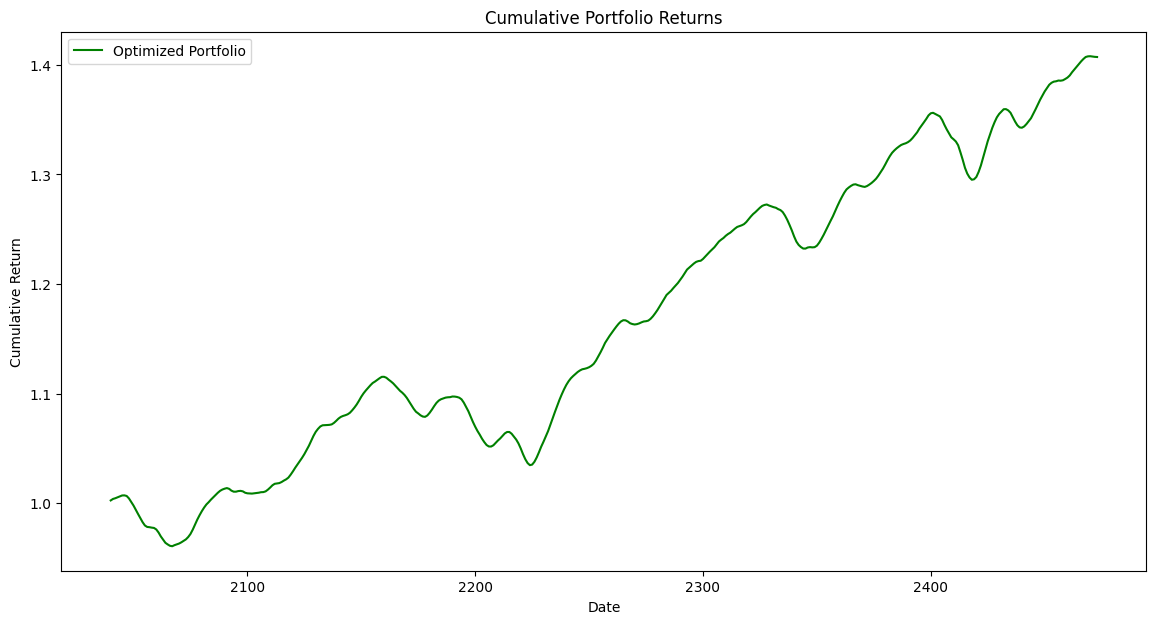

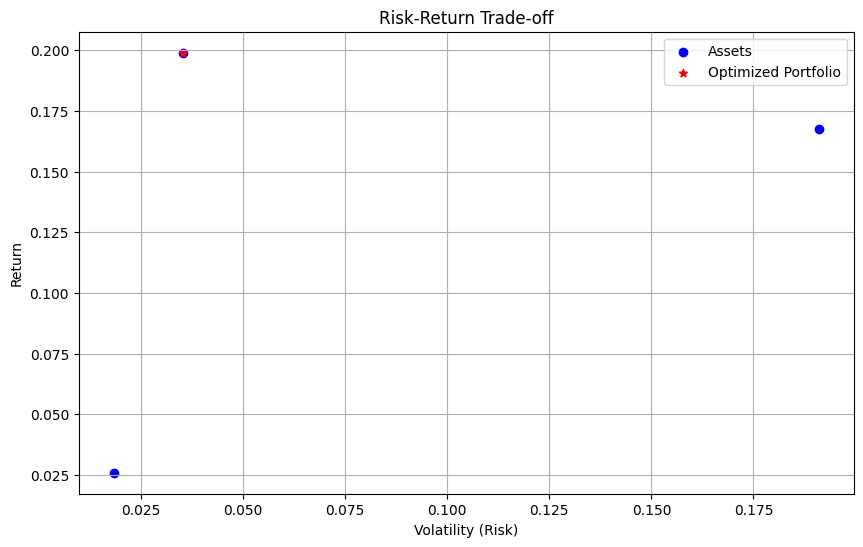

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load forecasted data for each asset
tsla_forecast = pd.read_csv("../data/Lstm_forecast_TSLA.csv", index_col=0)
bnd_forecast = pd.read_csv("../data/Lstm_forecast_BND.csv", index_col=0)
spy_forecast = pd.read_csv("../data/Lstm_forecast_SPY.csv", index_col=0)

# Combine the forecasted data into a single DataFrame
df = pd.DataFrame({
    'TSLA': tsla_forecast['LSTM_Forecast'],
    'BND': bnd_forecast['LSTM_Forecast'],
    'SPY': spy_forecast['LSTM_Forecast']
})

# Compute daily returns
returns = df.pct_change().dropna()

# Calculate annualized return for each asset
annual_returns = returns.mean() * 252

# Calculate the covariance matrix of daily returns
cov_matrix = returns.cov() * 252

# Define portfolio optimization
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    """
    Calculate portfolio return, risk (volatility), and Sharpe Ratio.
    """
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    """
    Objective function to minimize (negative Sharpe Ratio).
    """
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

def portfolio_volatility(weights, mean_returns, cov_matrix):
    """
    Portfolio volatility (used for risk minimization).
    """
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Constraints and bounds
num_assets = len(df.columns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # Weights between 0 and 1

# Initial guess (equal weights)
initial_weights = num_assets * [1. / num_assets]

# Optimize for maximum Sharpe Ratio
optimized_result = minimize(
    neg_sharpe_ratio, 
    initial_weights,
    args=(annual_returns, cov_matrix, 0.01),  # Risk-free rate = 0.01
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

# Extract optimized weights
optimized_weights = optimized_result.x

# Calculate portfolio performance metrics
portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_performance(
    optimized_weights, annual_returns, cov_matrix
)

# Calculate Value at Risk (VaR)
confidence_level = 0.95
VaR = np.percentile(returns @ optimized_weights, (1 - confidence_level) * 100)

# Summarize results
print("Optimized Portfolio Weights:")
for asset, weight in zip(df.columns, optimized_weights):
    print(f"{asset}: {weight:.2%}")
    
print(f"\nPortfolio Return: {portfolio_return:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Value at Risk (95% confidence): {VaR:.2%}")

# Visualize Cumulative Returns
cumulative_returns = (1 + (returns @ optimized_weights)).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label="Optimized Portfolio", color="green")
plt.title("Cumulative Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# Visualize Risk-Return Trade-off
plt.figure(figsize=(10, 6))
plt.scatter(np.sqrt(np.diag(cov_matrix)), annual_returns, c='blue', label="Assets")
plt.scatter(portfolio_volatility, portfolio_return, c='red', label="Optimized Portfolio", marker="*")
plt.title("Risk-Return Trade-off")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()